# Contents

### Module 2
- The Qasm Simulator
- Extending Circuits
- Barrier and Measurements
- Histogram Plots
- State initialization 
- Fidelity
- Custom Gates
- Decomposition / Transpilation

In [25]:
import numpy as np

### Circuit Simulators
Up until now, we've used deterministic maths to get State and Unitary information. Now we'll start sampling from the actual circuits we have. For this, we'll need measurements. Of course, with measurements, we'll have to deal with shot noise, meaning we have to average over many runs. Let's define a circuit basic simulator, and then a circuit simulator with QASM or AER.

The most straightforward way to do so is by importing the `BasicSimulator` from the providers

In [2]:
from qiskit.providers.basic_provider import BasicSimulator
backend = BasicSimulator()

Alternatively, we could have done this importing the wanted simulator from the qiskit_aer package

In [28]:
from qiskit_aer import QasmSimulator, AerSimulator

backend2 = QasmSimulator()
backend3 = AerSimulator()

From now on we will mainly make use of the AerSimulator since it's more often used in IBM material

Now let's create a generic and easy circuit to do our testing with

In [29]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

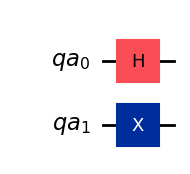

In [30]:
q_a = QuantumRegister(2, 'qa')
qc = QuantumCircuit(q_a)
qc.h(0)
qc.x(1)
qc.draw('mpl')

Now as you might notice, we still don't have any measurements in this circuit.
A quick and easy way to add measurements to all of your qubits is to use the measure_all method.

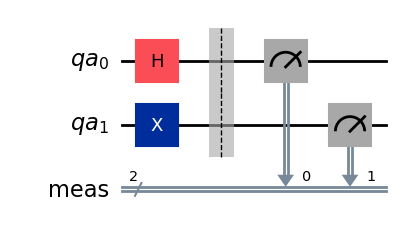

In [31]:
qc.measure_all()
qc.draw('mpl')

Now, as you can see, the measure_all method has added measurements to our circuit which had no classical registers or measurements prior. It is really important to know that this method creates new classical registers while adding measurements. So it's best employed for circuits that don't have pre-defined classical registers.

With that out of the way, now we have a circuit simulator and a circuit at our disposal. All that is left to do, is to actually perform the experiment. To start, we will perform a simulation using the previously defined backend.

In [32]:
from qiskit import transpile

new_circuit = transpile(qc, backend)

Since the current backend is a basic simulator without any "physical" constraint, `transpile` does not change the actual circuit. We can see this by printing the new circuit: 

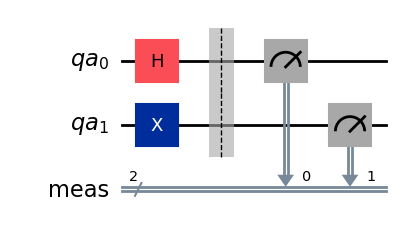

In [33]:
new_circuit.draw('mpl')

However, when using a more realistic backend, either a simulator targeting a real QPU or a REAL QPU, transpiling the circuits before running them is crucial. Now, let us look at the results from our simulation.

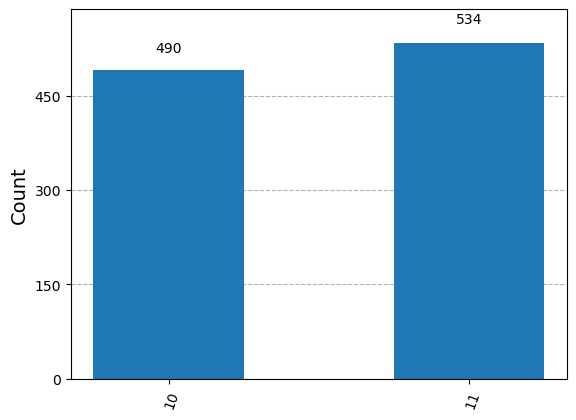

In [34]:
from qiskit.visualization import plot_histogram

job = backend.run(new_circuit)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

As we can see, running the experiment gave us our expected product state. However, notice now that the probabilities of getting these two computational states are not equal. This is the shot noise introducing the probabilistic nature of measurements. In principle, if we could do infinitely many measurements and average them, we'd get exactly 1/2 for each.

Let's now create a GHZ circuit for a similar demonstration. This time however, we'll be looking at another way to introduce measurements.

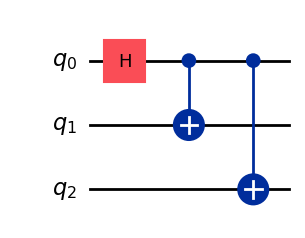

In [35]:
ghz = QuantumCircuit(3)
ghz.h(0)
ghz.cx(0,1)
ghz.cx(0,2)
ghz.draw('mpl')

Now, I'll be creating a separate circuit with explicit measurements. I could've done this within the circuit. But here we will kill 2 birds with one stone and employ the compose method.

Notice here, we are also for the first time utilizing this 'barrier' operation. 

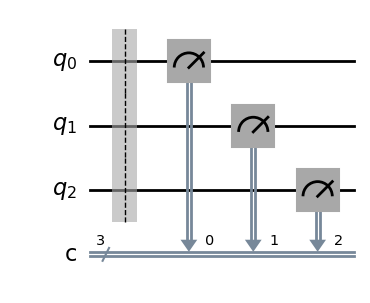

In [36]:
meas = QuantumCircuit(3,3)
meas.barrier()
meas.measure([0,1,2],[0,1,2])
meas.draw('mpl')

First of all, what is this barrier? The barrier operation is a direction for circuit compilation that says, seperate before and after the barrier while compiling. It is also used for making things clearer in priting circuits. For example if we'd have repeating chunks of the same circuit with different parameters but we'd like to be able to see clearly which is which, a barrier would be a good way to separate them.

Secondly, now I have two separate circuits. I have a GHZ circuit with no classical registers and measurements, and I have a measurement circuit with a barrier. Now I can use the compose method to put these circuits together and create a whole curcit. 

One important thing is, out of the box, compose works as adding the specified circuit to the tail of the existing circuit, so if we want to compose something beforehand, we must give it the flag front=True.

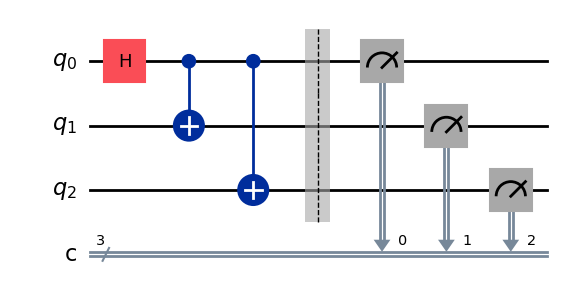

In [37]:
circ = meas.compose(ghz, range(3), front=True)
circ.draw('mpl')

Now that we have this new circuit with measurements, let's again run some experiments by sampling the circuit. 
And to really signify the stochastic nature of shot noise, let's sample the same circuit two times.

And this time, instead of getting nice histograms, just for completion, we'll get the counts themselves as a dictionary.

In [38]:
from qiskit_aer import AerSimulator

backend = AerSimulator(method="automatic")
circ = transpile(circ, backend)
job = backend.run(circ, shots=2000)

result = job.result()
counts = result.get_counts()
print(counts)

{'111': 1023, '000': 977}


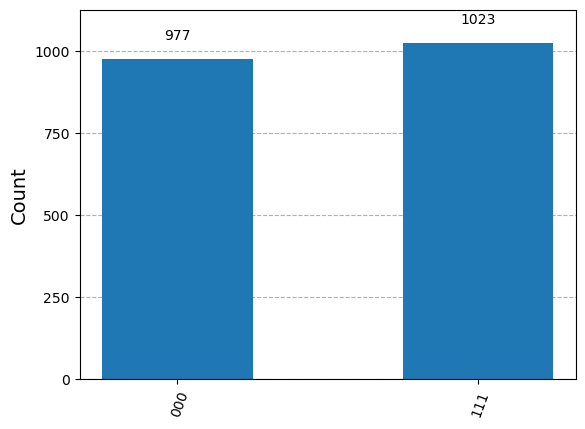

In [39]:
plot_histogram(counts)

In [41]:
job2 = backend.run(circ, shots=2000)
result2 = job2.result()
counts2 = result2.get_counts()
print(counts2)

{'000': 1037, '111': 963}


Now we have 2 different experiments from the same circuit, and we can already see that they don't perfectly match.
Furthermore, we could nicely visualize the two experiments with the plot_histograms method. Let's do that.

First of all, let's give the names as a legend list.

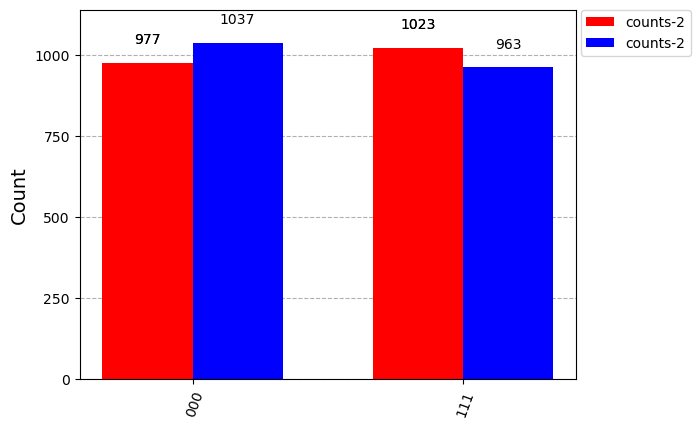

In [42]:
leg = ['counts-2', 'counts-2']
plot_histogram([counts, counts2], legend=leg, sort='asc', color=['red','blue'])

How about if we'd like to run experiments on an actual quantum machine provided by IBM?
This, we'll do on a separate notebook for runtime reasons!

Okay we've seen how we can run experiments on a QASM simulator, as well as how to visualize the results in histograms.
Now let's look at something a little different. Let's say, we have a quantum protocol in which we'd like to see how a specific state evolves. Can we initialize with this specific state? The answer is, yes. For simulation purposes.

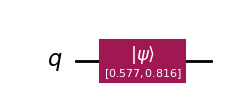

In [43]:
a = 1/np.sqrt(3)
desired_state = [a, np.sqrt(1-a**2)]

q_reg = QuantumRegister(1, 'q')
qc = QuantumCircuit(q_reg)
qc.initialize(desired_state, 0)
qc.draw('mpl')

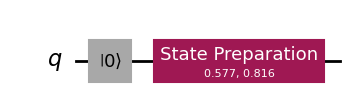

In [44]:
decomp = qc.decompose()
decomp.draw('mpl')

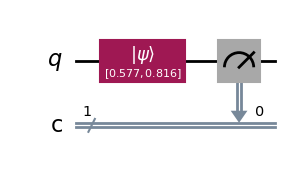

In [45]:
c_reg = ClassicalRegister(1, 'c')
meas = QuantumCircuit(q_reg, c_reg)
meas.measure(0,0)
circ = meas.compose(qc, range(1), front=True)
circ.draw('mpl')

Let's check if the State prep. and the QASM simulators match up?

In [46]:
alpha_squared = 0.577**2
beta_squared = 0.816**2
print(alpha_squared, beta_squared)

0.332929 0.6658559999999999


{'1': 670, '0': 330}


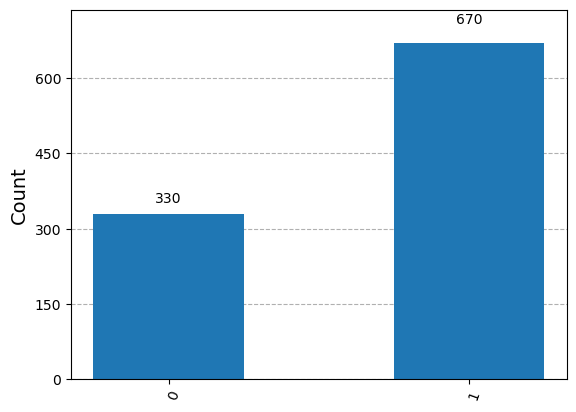

In [47]:
circ = transpile(circ, backend)
job = backend.run(circ, shots=1000)
counts = job.result().get_counts()
print(counts)
plot_histogram(counts)

How about the statevector that we acquire from this initialization, and what about the Operator form?

Really important to note here that the Unitary simulation of this circuit would not work because the qubit reset operation is not supported as of Qiskit 1.0

In [48]:
from qiskit.quantum_info import Statevector
qc_sv = Statevector(qc)
qc_sv

Statevector([0.57735027+0.j, 0.81649658+0.j],
            dims=(2,))


In [49]:
from qiskit.quantum_info import Operator
from qiskit.exceptions import QiskitError

try:
    Operator(qc)
except QiskitError:
    print("Error raised as expected")

Error raised as expected


State and Gate/Process fidelity are two very important concepts in Quantum Information, let's now see how we can play with these within Qiskit.

For the state process, let's compare the defined desired state (which is a numpy array defined by us) and the state obtained from the simulation. We know if everything worked perfectly during state preparation, we should get Fidelity = 1.

In [50]:
from qiskit.quantum_info import state_fidelity
state_fidelity(desired_state, qc_sv)

1.0

Now that we've checked state fidelity, how about gate/process fidelity?
To do this, let's also see a new way of calling a Gate definition directly and wrap it up as a Unitary operator object like we've done in the last lecture. We'll then also create another operator just differing from the first by an overall phase, and thus if we compare the fidelities, we should find they are the same. Let's see how this works.

In [51]:
from qiskit.circuit.library import XGate
from qiskit.quantum_info import Operator, process_fidelity, average_gate_fidelity

op_a = Operator(XGate())
op_b = np.exp(1j/2)*op_a

a = process_fidelity(op_a, op_b)
a

1.0

In [52]:
b = average_gate_fidelity(op_a, op_b)
a == b

True

Now we'll do something quite distinct to what we've been doing so far.
So far we've been using pre-defined gates from a pretty well known gate set to construct circuits.
And this makes sense, because universality implies that whichever gate we use really don't matter theoretically.
Of course that argument doesn't take into account how efficient a circuit can be, or for the programmer, how easy it will be to write a quantum program.

For the latter point, we'll be looking at how we can create custom gates via. different approaches.

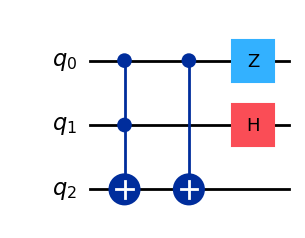

In [53]:
qc = QuantumCircuit(3)
qc.mcx([0,1],2)
qc.cx(0,2)
qc.h(1)
qc.z(0)
qc.draw('mpl')

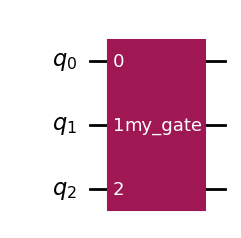

In [54]:
qc_gate = qc.to_gate()
qc_gate.name ='my_gate'

circ = QuantumCircuit(3)
circ.append(qc_gate, [0,1,2])
circ.draw('mpl')

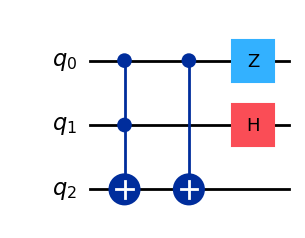

In [55]:
circ_decomp = circ.decompose()
circ_decomp.draw('mpl')

What if I want to create a controlled, or better yet a multi-controlled version of a generic gate?

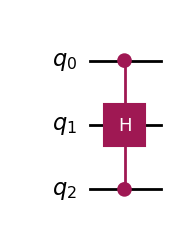

In [56]:
from qiskit.circuit.library import HGate
ch = HGate().control(2)

qc = QuantumCircuit(3)
qc.append(ch, [0,2,1])
qc.draw('mpl')

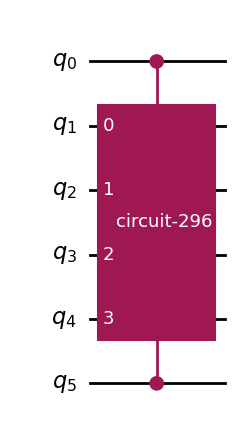

In [57]:
circ = QuantumCircuit(4)
circ.h(range(2))
circ.cx(0,1)
circ.cx(0,3)
circ.crz(np.pi/2, 0, 2)

my_gate = circ.to_gate().control(2)
qc = QuantumCircuit(6)
qc.append(my_gate, [0, 5, 1, 2, 3, 4])
qc.draw('mpl')

Let's decompose this complicated gate definition?

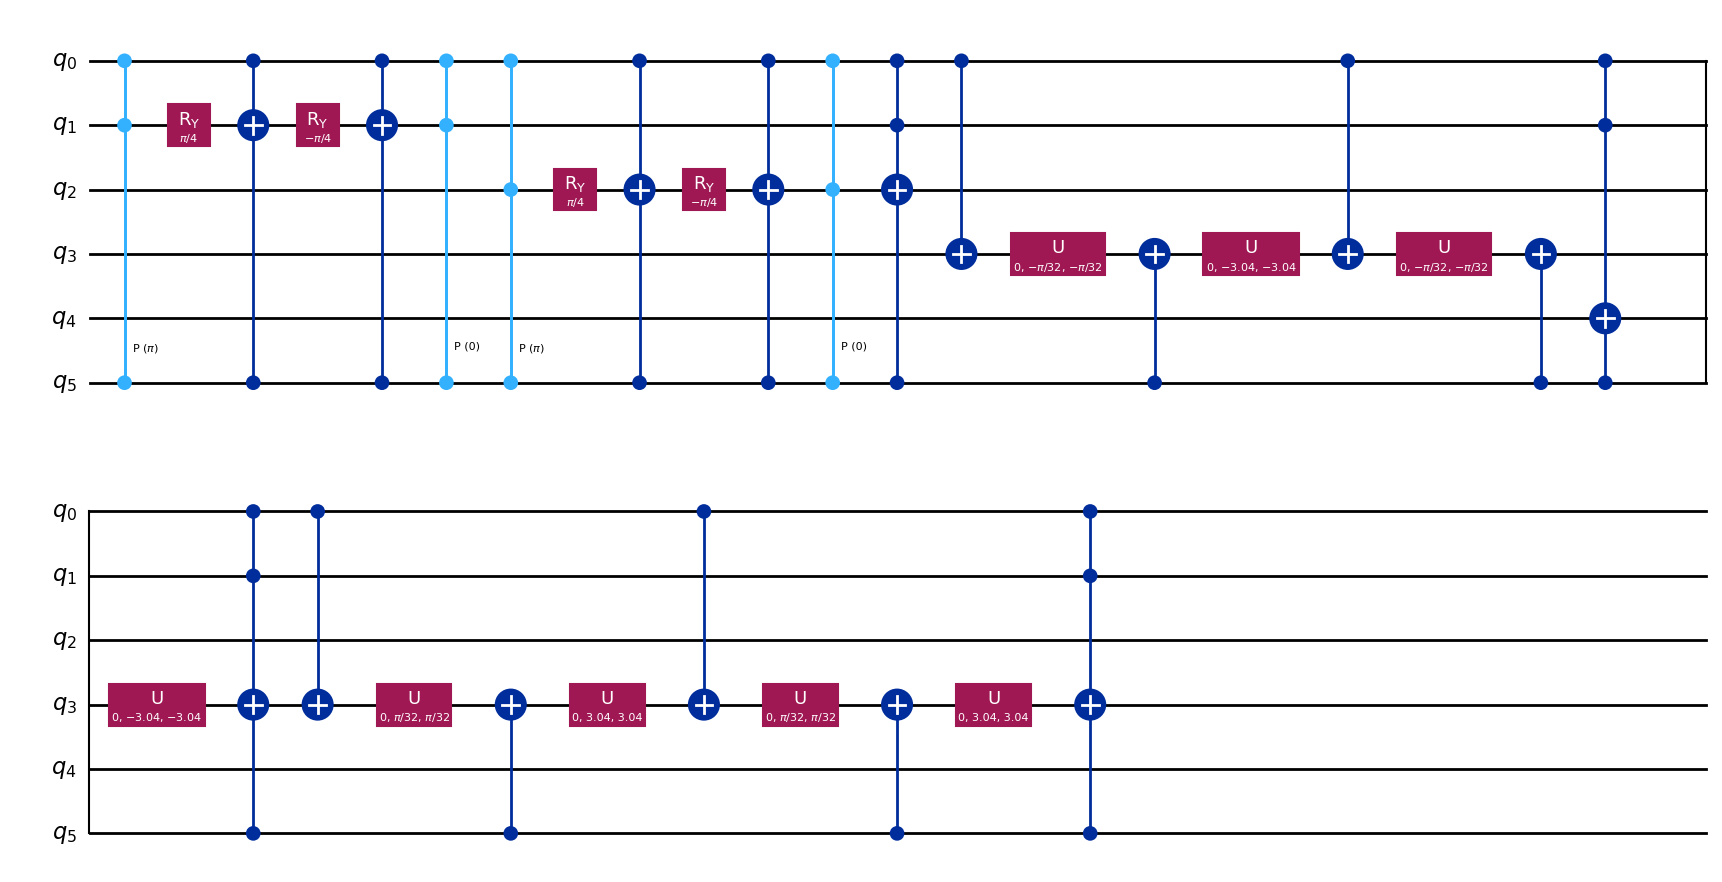

In [56]:
circ = qc.decompose()
circ.draw('mpl')

Let's lastly look at what happens if I'd like to transpile to a certain basis?

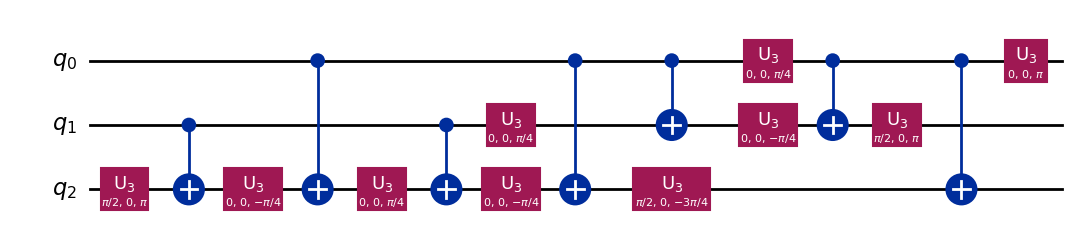

In [57]:
qc = QuantumCircuit(3)
qc.mcx([0,1],2)
qc.cx(0,2)
qc.h(1)
qc.z(0)

trans = transpile(qc, basis_gates = ['u3', 'cx', 's'])
trans.draw('mpl')

That's it for today!